In [1]:
import ioutils 
import matplotlib.pyplot as plt
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, GenerationConfig
import torch
import numpy as np
import pickle
import pandas as pd

/home/tyfei/anaconda3/envs/esm3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import pandas as pd
import numpy as np 
import ioutils
import os

from esm.models.esmc import ESMC
import warnings
warnings.filterwarnings("ignore")
model = ESMC.from_pretrained("esmc_600m", torch.device("cpu"))

In [18]:
s = ioutils.readFasta("/data/lisiqi/GLM/S_sample_1W.aln.fa", checkseq=None)
df = pd.read_csv("/data/lisiqi/GLM/metadata_sample_1W_all.csv", index_col=0)
# "OEAV176579" in list(df["id"])
len(df)
allseqs = {i[0]:i[1] for i in s}

In [ ]:
df = df[~pd.isna(df["scorpio_call"])]
df["lin"] = df["scorpio_call"].apply(lambda x: x[:x.find(" ")])
df = df[df["lin"].isin(['Beta', 'Delta', 'Alpha', 'Omicron',])]
df = df.groupby('lin', group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=1013))
df = df.set_index("id")
df.head()

,release_date,country,lineage,scorpio_call,year_month,lin
id,,,,,,
OEAV672016,2021-01-04,United Kingdom,B.1.1.7,Alpha (B.1.1.7-like),2021-01,Alpha
OEAV774210,2021-02-26,Netherlands,B.1.1.7,Alpha (B.1.1.7-like),2021-02,Alpha
OEAV2271315,2021-03-25,Germany,B.1.1.7,Alpha (B.1.1.7-like),2021-03,Alpha
OEAV2566981,2021-06-09,Germany,B.1.1.7,Alpha (B.1.1.7-like),2021-06,Alpha
OEAV2509272,2021-06-20,Germany,B.1.1.7,Alpha (B.1.1.7-like),2021-06,Alpha


In [ ]:
# random.seed(1013)
# selected = random.sample(df["id"], 2000)
# df = df.set_index("id")
data = [] 
for i in df.index:
    d = {} 
    d["lin"] = df.loc[i]["lin"]
    s = allseqs[i] 
    s = s.replace("-", "") 
    d["seq"] = s 
    protein = ESMProtein(sequence=d["seq"]) 
    res_s = model.encode(protein)
    d["input"] = {"Spike": res_s.sequence.cpu()}
    data.append(d)

In [21]:
import json 
import torch
import numpy as np
import pickle
import trainUtils
import pytorch_lightning as pl
with open("/data2/tyfei/trainresults/evomodel/train_siqi/config.json") as f:
    configs = json.load(f)

In [22]:
pretrain_model = trainUtils.loadPretrainModel(configs)
model = trainUtils.buildModel(configs, pretrain_model, None)
ds = trainUtils.loadDataset(configs)

model at stage: training stage 1


Seed set to 1509


In [23]:
ckpt = torch.load("/data2/tyfei/trainresults/evomodel/train_siqi/epoch=7-validation_loss=0.8193.ckpt")
model.load_state_dict(ckpt["state_dict"], strict=False)
# ckpt

_IncompatibleKeys(missing_keys=['esm_model.esm_model.embed.weight', 'esm_model.esm_model.transformer.blocks.0.attn.layernorm_qkv.0.weight', 'esm_model.esm_model.transformer.blocks.0.attn.layernorm_qkv.0.bias', 'esm_model.esm_model.transformer.blocks.0.attn.layernorm_qkv.1.linear.weight', 'esm_model.esm_model.transformer.blocks.0.attn.out_proj.linear.weight', 'esm_model.esm_model.transformer.blocks.0.attn.q_ln.weight', 'esm_model.esm_model.transformer.blocks.0.attn.k_ln.weight', 'esm_model.esm_model.transformer.blocks.0.ffn.0.weight', 'esm_model.esm_model.transformer.blocks.0.ffn.0.bias', 'esm_model.esm_model.transformer.blocks.0.ffn.1.linear.weight', 'esm_model.esm_model.transformer.blocks.0.ffn.3.linear.weight', 'esm_model.esm_model.transformer.blocks.1.attn.layernorm_qkv.0.weight', 'esm_model.esm_model.transformer.blocks.1.attn.layernorm_qkv.0.bias', 'esm_model.esm_model.transformer.blocks.1.attn.layernorm_qkv.1.linear.weight', 'esm_model.esm_model.transformer.blocks.1.attn.out_proj.

In [25]:
data

[{'lin': 'Alpha',
  'seq': 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAXXSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGXXYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIDDTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPINFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAI

In [26]:
dl = ds.train_dataloader() 
resS2 = [] 
resS1 = []
# label = []
cnt = 0
model = model.cuda(0)
model.stage = "training stage 1"
with torch.no_grad():
    for i in data:        # print(i)
        a1 = {"Spike": i["input"]["Spike"]}
        # label.append(i["lin"]) 
        for i in a1:
            a1[i] = a1[i].cuda(0) 
        
        t = model(a1)
        # resS2.append(t.S2Embeddings.cpu().squeeze().numpy())
        resS1.append(t.S1Embeddings["Spike"].cpu().squeeze().numpy())
        # t = model(a1).S1Embeddings.cpu().squeeze().numpy()
        for i in a1:
            a1[i] = a1[i].cpu()
        cnt += 1 
        if cnt%100 == 0:
            print(cnt)
        # print(cnt)
        # if cnt%1000 == 0:
        #     break

get train loader
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [27]:
from sklearn.decomposition import PCA
import numpy as np
q = np.stack(resS1, axis=0)
pca = PCA(n_components=20)
pca_seq = pca.fit_transform(q)
pca_seq.shape 
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(pca_seq)

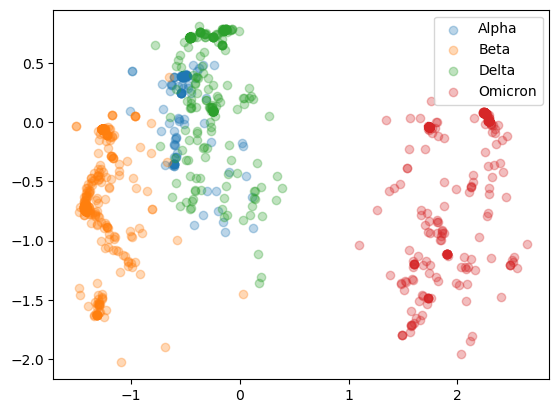

In [33]:
label = [i["lin"] for i in data]
df = pd.DataFrame({"x": pca_seq[:, 0], "y": pca_seq[:, 1], "labels": label})
for i in np.unique(df["labels"]):
    subdf = df[df["labels"] == i]
    plt.scatter(subdf["x"], subdf["y"], label=i, alpha=0.3)
plt.legend()